In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sb
sb.set(style="whitegrid")
%matplotlib inline

In [3]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 10, 7

In [4]:
from imblearn.under_sampling import TomekLinks

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

In [5]:
from time import time

## 1. Baja el archivo caudal_extra.csv

In [6]:
df = pd.read_csv("caudal_extra.csv", index_col=0)
df.head()

C:\Users\Satellite\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


codigo_estacion institucion   fuente                  nombre  altura  \
0          4540001         DGA  dga_web  Rio Grande En Paloma 1     310   
1          4540001         DGA  dga_web  Rio Grande En Paloma 1     310   
2          4540001         DGA  dga_web  Rio Grande En Paloma 1     310   
3          4540001         DGA  dga_web  Rio Grande En Paloma 1     310   
4          4540001         DGA  dga_web  Rio Grande En Paloma 1     310   

   latitud   longitud  codigo_cuenca  \
0 -30.6833 -71.050003             45   
1 -30.6833 -71.050003             45   
2 -30.6833 -71.050003             45   
3 -30.6833 -71.050003             45   
4 -30.6833 -71.050003             45   

                                nombre_sub_cuenca  cantidad_observaciones  \
0  Rio Grande Bajo (Entre E Paloma Y Rio Hurtado)                   11575   
1  Rio Grande Bajo (Entre E Paloma Y Rio Hurtado)                   11575   
2  Rio Grande Bajo (Entre E Paloma Y Rio Hurtado)                   11575   
3  Rio Grande Bajo (Entre E Paloma Y Rio Hurtado)                   11575   
4  Rio Grande Bajo (Entre E Paloma Y Rio Hurtado)                   11575   

                       fecha  caudal  gauge_id              gauge_name  \
0  1960-01-06 00:00:00+00:00   0.812   4540001  Rio Grande En Paloma 1   
1  1960-03-27 00:00:00+00:00   0.236   4540001  Rio Grande En Paloma 1   
2  1960-05-07 00:00:00+00:00   0.730   4540001  Rio Grande En Paloma 1   
3  1960-06-30 00:00:00+00:00   3.590   4540001  Rio Grande En Paloma 1   
4  1960-07-22 00:00:00+00:00   1.370   4540001  Rio Grande En Paloma 1   

   precip_promedio  temp_max_promedio  
0              0.0                NaN  
1              0.0                NaN  
2              0.0                NaN  
3              0.0                NaN  
4              0.0                NaN

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1411180 entries, 0 to 1411179
Data columns (total 16 columns):
codigo_estacion           1411180 non-null int64
institucion               1411180 non-null object
fuente                    1411180 non-null object
nombre                    1411180 non-null object
altura                    1411180 non-null int64
latitud                   1411180 non-null float64
longitud                  1411180 non-null float64
codigo_cuenca             1411180 non-null int64
nombre_sub_cuenca         1411180 non-null object
cantidad_observaciones    1411180 non-null int64
fecha                     1411180 non-null object
caudal                    1411180 non-null float64
gauge_id                  1411180 non-null int64
gauge_name                1411180 non-null object
precip_promedio           1383413 non-null float64
temp_max_promedio         1259617 non-null float64
dtypes: float64(5), int64(5), object(6)
memory usage: 183.0+ MB


In [8]:
df.isnull().sum()

codigo_estacion                0
institucion                    0
fuente                         0
nombre                         0
altura                         0
latitud                        0
longitud                       0
codigo_cuenca                  0
nombre_sub_cuenca              0
cantidad_observaciones         0
fecha                          0
caudal                         0
gauge_id                       0
gauge_name                     0
precip_promedio            27767
temp_max_promedio         151563
dtype: int64

In [9]:
df.nunique()

codigo_estacion             133
institucion                   1
fuente                        1
nombre                      133
altura                      101
latitud                     133
longitud                    130
codigo_cuenca                29
nombre_sub_cuenca            78
cantidad_observaciones      132
fecha                     21252
caudal                    29154
gauge_id                    133
gauge_name                  133
precip_promedio           33004
temp_max_promedio         35729
dtype: int64

### Chequear variable "gauge_id"

In [10]:
df[['codigo_estacion', 'gauge_id']].sample(5)

codigo_estacion  gauge_id
230537         11711000  11711000
510998          7359001   7359001
405441          3806001   3806001
159009          3820003   3820003
979683          4513001   4513001

In [11]:
# Comprobar que para ningún registro 'codigo_estacion' sea distinto a 'gauge_id':
len(df[df['codigo_estacion']!=df['gauge_id']])

0

### Chequear variable "fecha"

In [12]:
df['fecha'] = pd.to_datetime(df['fecha'])
df['hora'] = df['fecha'].dt.time
df['hora'].describe()

count      1411180
unique           1
top       00:00:00
freq       1411180
Name: hora, dtype: object

### Aplicar transformaciones pertinentes al dataset

In [13]:
# Convertir variable "fecha" a tipo "datetime":
df['fecha'] = df['fecha'].dt.date
df['fecha'] = pd.to_datetime(df['fecha'])

# Eliminar las columnas que no son necesarias:
df.drop(
    ['institucion', 
     'fuente',
     'nombre',
     'nombre_sub_cuenca',
     'cantidad_observaciones',
     'hora',
     'gauge_id',
     'gauge_name'], axis=1, inplace=True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1411180 entries, 0 to 1411179
Data columns (total 9 columns):
codigo_estacion      1411180 non-null int64
altura               1411180 non-null int64
latitud              1411180 non-null float64
longitud             1411180 non-null float64
codigo_cuenca        1411180 non-null int64
fecha                1411180 non-null datetime64[ns]
caudal               1411180 non-null float64
precip_promedio      1383413 non-null float64
temp_max_promedio    1259617 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(3)
memory usage: 107.7 MB


In [15]:
df.head()

codigo_estacion  altura  latitud   longitud  codigo_cuenca      fecha  \
0          4540001     310 -30.6833 -71.050003             45 1960-01-06   
1          4540001     310 -30.6833 -71.050003             45 1960-03-27   
2          4540001     310 -30.6833 -71.050003             45 1960-05-07   
3          4540001     310 -30.6833 -71.050003             45 1960-06-30   
4          4540001     310 -30.6833 -71.050003             45 1960-07-22   

   caudal  precip_promedio  temp_max_promedio  
0   0.812              0.0                NaN  
1   0.236              0.0                NaN  
2   0.730              0.0                NaN  
3   3.590              0.0                NaN  
4   1.370              0.0                NaN

## 2. Analiza el dataset caudal_extra.csv. ¿Qué puedes decir de los datos, distribuciones, missing, u otros? ¿Hay algo que te llame la atención? ¿Por qué hay tantos valores missing? Pensar en la manera en que se elaboró el dataset, descrito más arriba. (Entregable: texto/imágenes)

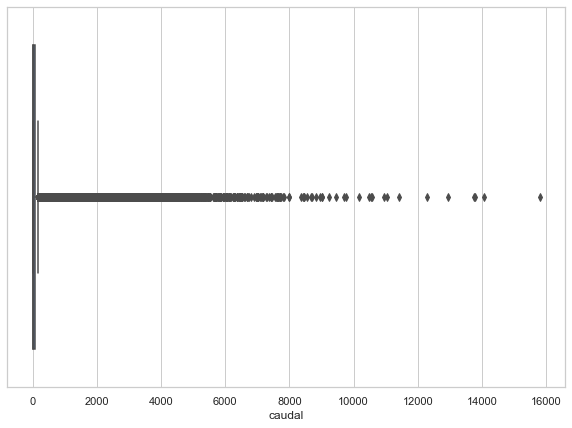

In [16]:
sb.boxplot(df['caudal'])

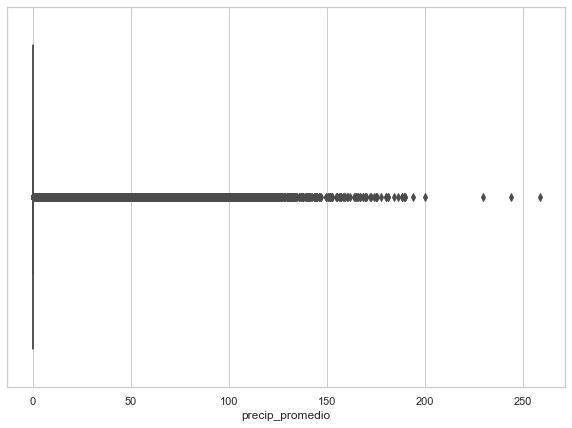

In [17]:
sb.boxplot(df['precip_promedio'])

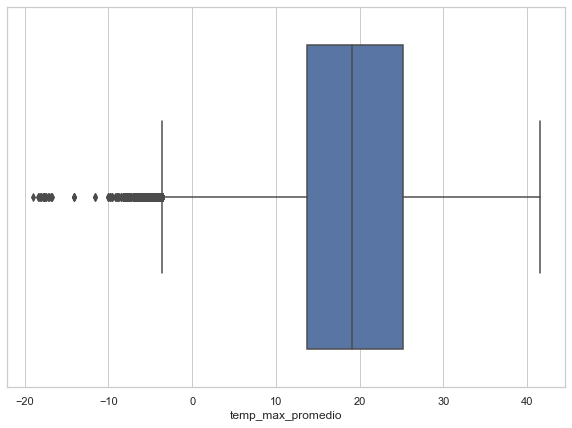

In [18]:
sb.boxplot(df['temp_max_promedio'])

Como se puede evidenciar en los boxplots graficados arriba, las variables "caudal" y "precip_promedio" están muy lejos de tener distribuciones normales, con una acentuada asimetría positiva concentrándose la mayoría de sus valores cerca de cero. También llama la atención el contraste con respecto a las enormes magnitudes de los valores atípicos en ambos casos. En cambio, la variable "temp_max_promedio" sí posee una distribución más cercana a la distribución normal, destacando además que los valores atípicos se hallan en el rango de temperaturas mínimas.

Ahora, revisemos las correlaciones entre las variables aplicando tanto el método de Pearson como el método de Spearman para calcular las mismas.

In [19]:
df.corr()

codigo_estacion    altura   latitud  longitud  \
codigo_estacion           1.000000 -0.592091 -0.979942 -0.859722   
altura                   -0.592091  1.000000  0.635112  0.768335   
latitud                  -0.979942  0.635112  1.000000  0.846466   
longitud                 -0.859722  0.768335  0.846466  1.000000   
codigo_cuenca             0.991038 -0.573129 -0.969998 -0.839962   
caudal                    0.379055 -0.198266 -0.348209 -0.390946   
precip_promedio           0.163647 -0.094212 -0.136393 -0.161121   
temp_max_promedio        -0.285342 -0.111890  0.237541  0.103177   

                   codigo_cuenca    caudal  precip_promedio  temp_max_promedio  
codigo_estacion         0.991038  0.379055         0.163647          -0.285342  
altura                 -0.573129 -0.198266        -0.094212          -0.111890  
latitud                -0.969998 -0.348209        -0.136393           0.237541  
longitud               -0.839962 -0.390946        -0.161121           0.103177  
codigo_cuenca           1.000000  0.380675         0.162695          -0.297615  
caudal                  0.380675  1.000000         0.191504          -0.233441  
precip_promedio         0.162695  0.191504         1.000000          -0.259801  
temp_max_promedio      -0.297615 -0.233441        -0.259801           1.000000

Las correlaciones más altas se dan entre las variables "codigo_estacion", "altura", "latitud", "longitud" y "codigo_cuenca". Esto en principio no es muy útil, pero claramente se puede intuir que la asignación de los códigos tiene una connotación geográfica, lo que puede ayudar a reducir la cantidad de variables independientes.

In [20]:
df.corr(method='spearman')

codigo_estacion    altura   latitud  longitud  \
codigo_estacion           1.000000 -0.577544 -0.994038 -0.904755   
altura                   -0.577544  1.000000  0.539298  0.747021   
latitud                  -0.994038  0.539298  1.000000  0.886270   
longitud                 -0.904755  0.747021  0.886270  1.000000   
codigo_cuenca             0.988028 -0.543543 -0.991459 -0.881848   
caudal                    0.737018 -0.400426 -0.732183 -0.679764   
precip_promedio           0.375476 -0.246100 -0.371260 -0.365379   
temp_max_promedio        -0.274290  0.052741  0.282811  0.185163   

                   codigo_cuenca    caudal  precip_promedio  temp_max_promedio  
codigo_estacion         0.988028  0.737018         0.375476          -0.274290  
altura                 -0.543543 -0.400426        -0.246100           0.052741  
latitud                -0.991459 -0.732183        -0.371260           0.282811  
longitud               -0.881848 -0.679764        -0.365379           0.185163  
codigo_cuenca           1.000000  0.738464         0.370630          -0.280487  
caudal                  0.738464  1.000000         0.389995          -0.307073  
precip_promedio         0.370630  0.389995         1.000000          -0.452972  
temp_max_promedio      -0.280487 -0.307073        -0.452972           1.000000

En el caso del método Spearman, nos concentramos más bien en las correlaciones con respecto a la variable "caudal", viendo que las variables de tipo geográfica y los códigos son las que presentan correlaciones altas. 

Ahora veamos los gráficos de dispersión (scatterplots) de todas las variables con respecto a la variable "caudal".

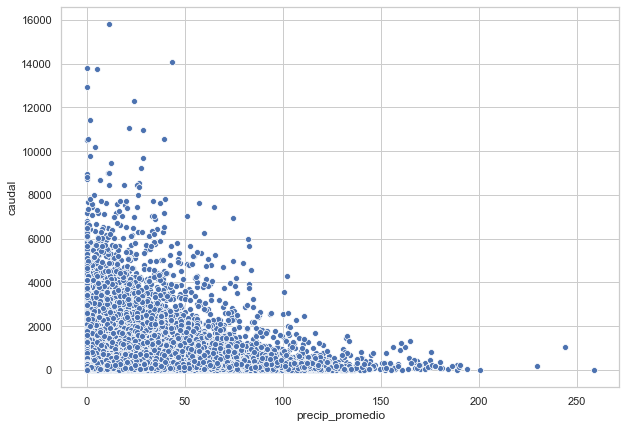

In [21]:
sb.scatterplot(x='precip_promedio', y='caudal', data=df)

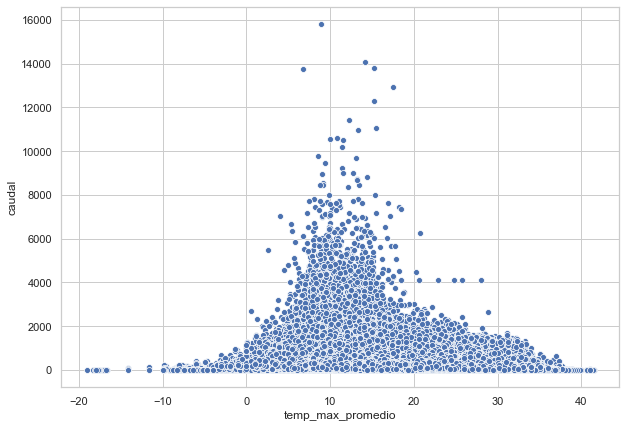

In [22]:
sb.scatterplot(x='temp_max_promedio', y='caudal', data=df)

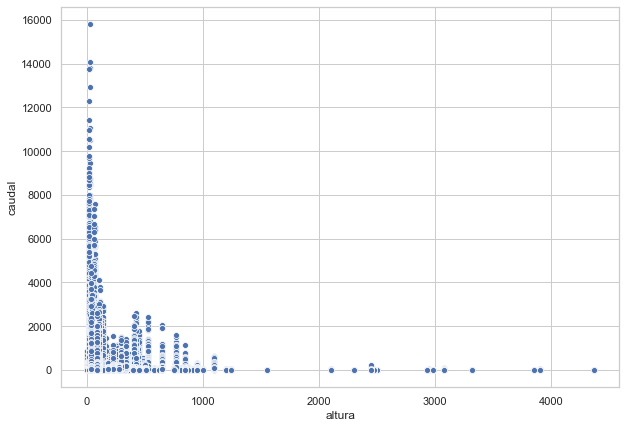

In [23]:
sb.scatterplot(x='altura', y='caudal', data=df)

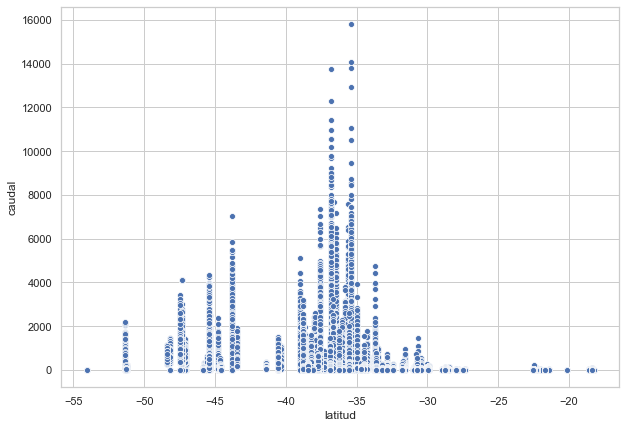

In [24]:
sb.scatterplot(x='latitud', y='caudal', data=df)

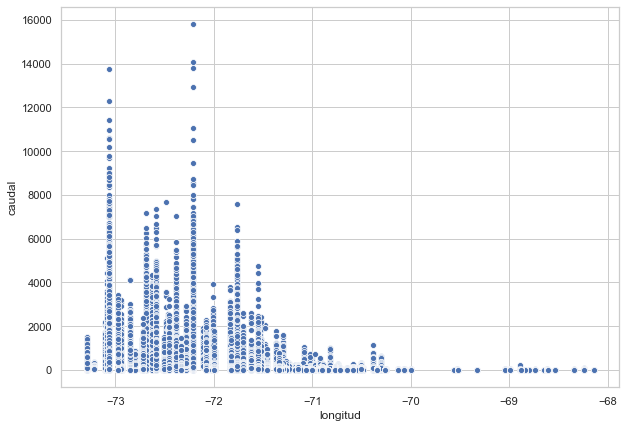

In [25]:
sb.scatterplot(x='longitud', y='caudal', data=df)

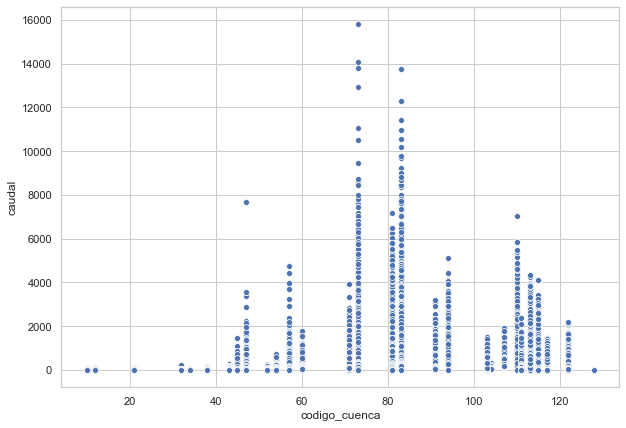

In [26]:
sb.scatterplot(x='codigo_cuenca', y='caudal', data=df)

En ninguno de los gráficos de dispersión se puede apreciar una clara correlación lineal con respecto a la variable "caudal". No obstante, se puede observar que los valores más altos de caudal tienden a concentrarse en un determinado rango de cada variable independiente.

Ahora grafiquemos las variables "temp_max_promedio" y "precip_promedio".

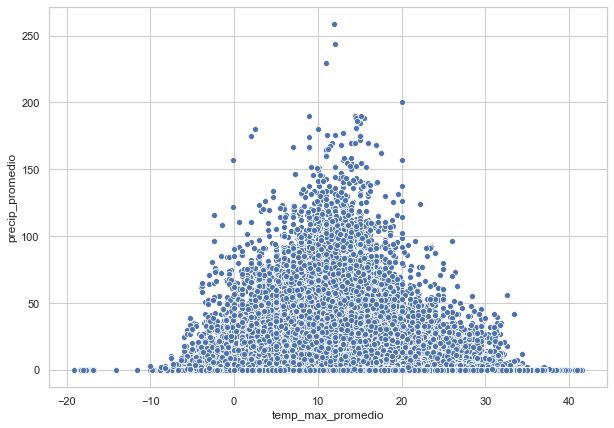

In [27]:
sb.scatterplot(x='temp_max_promedio', y='precip_promedio', data=df)

En este caso sucede un fenómeno similar: no se aprecia una clara correlación lineal, y además los valores más altos de precipitación se concentran en un rango de la temperatura.

Para continuar con el análisis, eliminamos aquellos registros que posean valores nulos, bien sean de precipitación o de temperatura. 

In [28]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1256478 entries, 32 to 1411179
Data columns (total 9 columns):
codigo_estacion      1256478 non-null int64
altura               1256478 non-null int64
latitud              1256478 non-null float64
longitud             1256478 non-null float64
codigo_cuenca        1256478 non-null int64
fecha                1256478 non-null datetime64[ns]
caudal               1256478 non-null float64
precip_promedio      1256478 non-null float64
temp_max_promedio    1256478 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(3)
memory usage: 95.9 MB


In [29]:
df.describe()

codigo_estacion        altura       latitud      longitud  \
count     1.256478e+06  1.256478e+06  1.256478e+06  1.256478e+06   
mean      6.270140e+06  5.902867e+02 -3.365224e+01 -7.121523e+01   
std       2.906719e+06  8.810602e+02  6.998293e+00  1.193651e+00   
min       1.020003e+06  0.000000e+00 -5.404110e+01 -7.328330e+01   
25%       4.320001e+06  4.200000e+01 -3.686670e+01 -7.206810e+01   
50%       5.734001e+06  3.100000e+02 -3.359390e+01 -7.126580e+01   
75%       8.307002e+06  7.500000e+02 -2.994580e+01 -7.053280e+01   
max       1.287600e+07  4.370000e+03 -1.823250e+01 -6.814390e+01   

       codigo_cuenca        caudal  precip_promedio  temp_max_promedio  
count   1.256478e+06  1.256478e+06     1.256478e+06       1.256478e+06  
mean    6.244692e+01  1.006744e+02     1.924264e+00       1.921806e+01  
std     2.852077e+01  2.631270e+02     7.363496e+00       7.305359e+00  
min     1.000000e+01  0.000000e+00     0.000000e+00      -1.905000e+01  
25%     4.300000e+01  1.200000e+00     0.000000e+00       1.370000e+01  
50%     5.700000e+01  9.420000e+00     0.000000e+00       1.910000e+01  
75%     8.300000e+01  7.390000e+01     0.000000e+00       2.520000e+01  
max     1.280000e+02  1.580500e+04     2.586000e+02       4.150000e+01

## 3. Plots de precipitación, temperatura y caudal

### a. Escribir una función que tome como input una estación y haga plot de los datos para una columna.

In [30]:
def time_plot_una_estacion(codigo_estacion, columna, fecha_min, fecha_max):
    data = df[df['codigo_estacion']==codigo_estacion]
    data.plot.line(x='fecha', y=columna)
    plt.axis(xmin=fecha_min, xmax=fecha_max)

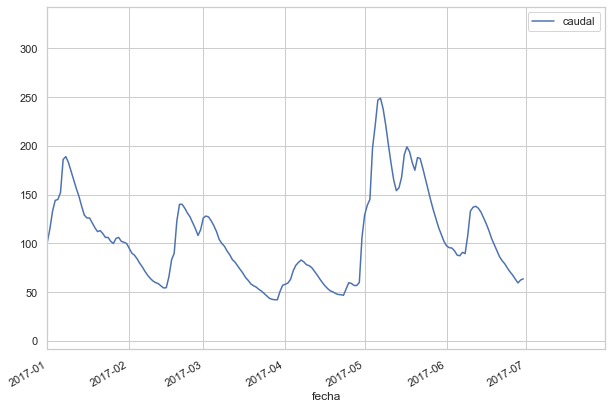

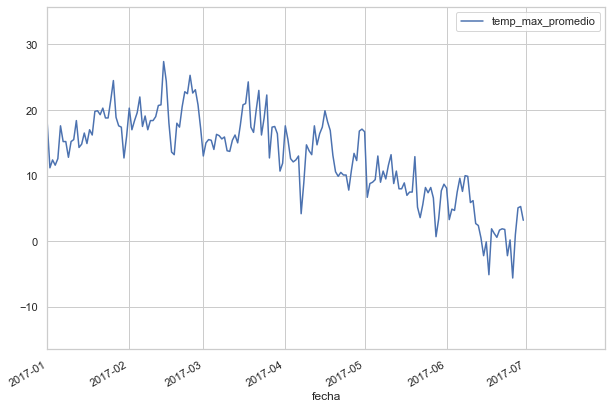

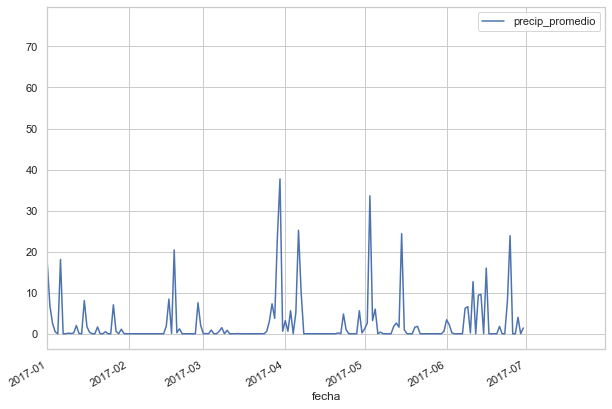

In [31]:
time_plot_una_estacion(11335002, 'caudal', '2017-01-01', '2017-07-31')
time_plot_una_estacion(11335002, 'temp_max_promedio', '2017-01-01', '2017-07-31')
time_plot_una_estacion(11335002, 'precip_promedio', '2017-01-01', '2017-07-31')

### b. Ahora escribir una función que haga plots de varias columnas, para poder visualizar caudal, precipitación y temperatura al mismo tiempo.

In [32]:
def time_plot_estaciones_varias_columnas(codigo_estacion, columnas, fecha_min, fecha_max):
    data = df[df['codigo_estacion']==codigo_estacion]
    data = data.set_index('fecha')
    data = data[columnas]
    data.plot.line()
    plt.axis(xmin=fecha_min, xmax=fecha_max)

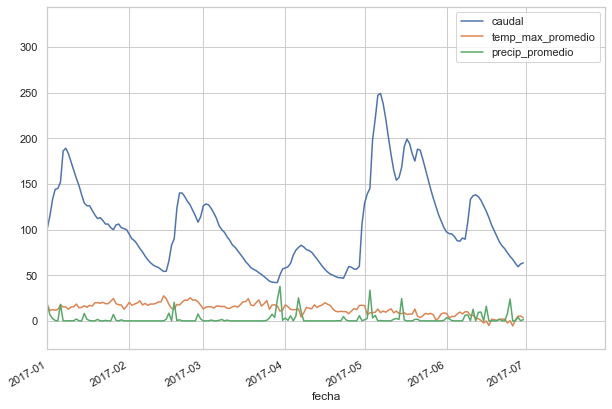

In [33]:
time_plot_estaciones_varias_columnas(11335002, 
                                     ['caudal', 'temp_max_promedio', 'precip_promedio'], 
                                     '2017-01-01', 
                                     '2017-07-31')

## 4. Crea tres variables llamadas caudal_extremo, temp_extremo, precip_extremo

In [34]:
df['mes'] = df['fecha'].dt.month
df.groupby(by='mes')['temp_max_promedio'].mean()

mes
1     24.915142
2     24.866084
3     23.193485
4     19.695611
5     16.042813
6     13.469314
7     13.052053
8     14.605500
9     16.712071
10    19.152808
11    21.530888
12    23.598806
Name: temp_max_promedio, dtype: float64

In [35]:
df['estacion_año'] = df['fecha'].dt.month

estaciones = {1:'verano', 
              2:'verano', 
              3:'otoño', 
              4:'otoño', 
              5:'otoño', 
              6:'invierno', 
              7:'invierno', 
              8:'invierno', 
              9:'primavera', 
              10:'primavera', 
              11:'primavera', 
              12:'verano'}

df['estacion_año'] = df['estacion_año'].map(estaciones)

In [36]:
df.sample(3)

codigo_estacion  altura    latitud   longitud  codigo_cuenca  \
1208560          5734001     500 -33.198299 -70.895599             57   
1153907          8135002      29 -36.650002 -72.449997             81   
696229           3431001     915 -27.804399 -70.126900             34   

             fecha  caudal  precip_promedio  temp_max_promedio  mes  \
1208560 1976-09-19   0.421         0.000000          21.000000    9   
1153907 1967-01-18  61.000        35.977779          12.500000    1   
696229  2006-02-22   2.260         0.000000          30.166666    2   

        estacion_año  
1208560    primavera  
1153907       verano  
696229        verano

In [37]:
caudal_p95 = df.groupby(by=['codigo_estacion', 'estacion_año'])['caudal'].quantile(0.95)
caudal_p95 = caudal_p95.rename('caudal_p95')
caudal_p95 = caudal_p95.reset_index()
caudal_p95.head()

codigo_estacion estacion_año  caudal_p95
0          1020003     invierno      0.2027
1          1020003        otoño      0.8655
2          1020003    primavera      0.1170
3          1020003       verano      1.2860
4          1021001     invierno      2.6000

In [38]:
temp_max_p95 = df.groupby(by=['codigo_estacion', 'estacion_año'])['temp_max_promedio'].quantile(0.95)
temp_max_p95 = temp_max_p95.rename('temp_max_p95')
temp_max_p95 = temp_max_p95.reset_index()
temp_max_p95.head()

codigo_estacion estacion_año  temp_max_p95
0          1020003     invierno        13.050
1          1020003        otoño        15.100
2          1020003    primavera        16.100
3          1020003       verano        16.196
4          1021001     invierno        13.000

In [39]:
precip_p95 = df.groupby(by=['codigo_estacion', 'estacion_año'])['precip_promedio'].quantile(0.95)
precip_p95 = precip_p95.rename('precip_p95')
precip_p95 = precip_p95.reset_index()
precip_p95.head()

codigo_estacion estacion_año  precip_p95
0          1020003     invierno    0.000000
1          1020003        otoño    5.278125
2          1020003    primavera    0.510000
3          1020003       verano   10.724000
4          1021001     invierno    0.000000

In [40]:
df_p95 = pd.merge(caudal_p95, temp_max_p95, on=['codigo_estacion', 'estacion_año'])
df_p95 = pd.merge(df_p95, precip_p95, on=['codigo_estacion', 'estacion_año'])
df_p95.head()

codigo_estacion estacion_año  caudal_p95  temp_max_p95  precip_p95
0          1020003     invierno      0.2027        13.050    0.000000
1          1020003        otoño      0.8655        15.100    5.278125
2          1020003    primavera      0.1170        16.100    0.510000
3          1020003       verano      1.2860        16.196   10.724000
4          1021001     invierno      2.6000        13.000    0.000000

In [41]:
df = pd.merge(df, df_p95, on=['codigo_estacion', 'estacion_año'])

df['caudal_extremo'] = (df['caudal'] > df['caudal_p95'])
df['temp_extremo'] = (df['temp_max_promedio'] > df['temp_max_p95'])
df['precip_extremo'] = (df['precip_promedio'] > df['precip_p95'])

df['caudal_extremo'] = df['caudal_extremo'].map({True:1, False:0})
df['temp_extremo'] = df['temp_extremo'].map({True:1, False:0})
df['precip_extremo'] = df['precip_extremo'].map({True:1, False:0})

df.sample(5)

codigo_estacion  altura    latitud   longitud  codigo_cuenca  \
188769           7116001     450 -35.173100 -71.091103             71   
529682           5410002     950 -32.850300 -70.509399             54   
1065089          5734001     500 -33.198299 -70.895599             57   
889548           8106001     410 -36.570301 -71.554703             81   
562513           8394001      16 -36.838600 -73.061897             83   

             fecha   caudal  precip_promedio  temp_max_promedio  mes  \
188769  2002-07-05    4.950         0.000000          11.500000    7   
529682  2001-06-23    8.980         1.266667          10.450000    6   
1065089 1998-12-03    0.122         0.000000          30.900000   12   
889548  1983-08-06   99.300         0.000000           9.500000    8   
562513  2005-11-05  987.000         0.000000          18.860001   11   

        estacion_año  caudal_p95  temp_max_p95  precip_p95  caudal_extremo  \
188769      invierno    55.47000     19.000000   45.500000               0   
529682      invierno    30.93000     24.100000   19.866667               0   
1065089       verano     0.54445     34.000000    0.000000               0   
889548      invierno   450.70000     19.180001   60.299999               0   
562513     primavera  2155.10000     25.200001   16.804255               0   

         temp_extremo  precip_extremo  
188769              0               0  
529682              0               0  
1065089             0               0  
889548              0               0  
562513              0               0

### ¿Les parece razonable esta medida para capturar algo “extremo”? ¿Usarían otra? ¿Cuál?

In [42]:
df_p95.mean()

codigo_estacion    6.610278e+06
caudal_p95         2.464737e+02
temp_max_p95       2.496213e+01
precip_p95         1.065595e+01
dtype: float64

En principio sí parece bastante razonable para las variables de caudal y precipitación, ya que esta medida logra capturar únicamente valores atípicos según lo mostrado en los boxplots de la sección 2.

## 5. Analicen la variable caudal_extremo. Los comportamientos en diferentes cuencas son muy diferentes?

In [43]:
round(df['caudal_extremo'].mean(), 6)

0.049874

In [44]:
promedio_caudal_extremo_cuenca = df.groupby(by='codigo_cuenca')['caudal_extremo'].mean().rename('promedio_caudal_extremo')
promedio_caudal_extremo_cuenca.reset_index()

codigo_cuenca  promedio_caudal_extremo
0              10                 0.049865
1              12                 0.049943
2              21                 0.049315
3              32                 0.049948
4              34                 0.049928
5              38                 0.049675
6              43                 0.049845
7              45                 0.049905
8              47                 0.050073
9              52                 0.050563
10             54                 0.049621
11             57                 0.049520
12             60                 0.049829
13             71                 0.049873
14             73                 0.049952
15             81                 0.049957
16             83                 0.050211
17             91                 0.049757
18             94                 0.050072
19            103                 0.050096
20            104                 0.047794
21            107                 0.050424
22            110                 0.050454
23            111                 0.049958
24            113                 0.049969
25            115                 0.050121
26            117                 0.049797
27            122                 0.050128
28            128                 0.061058

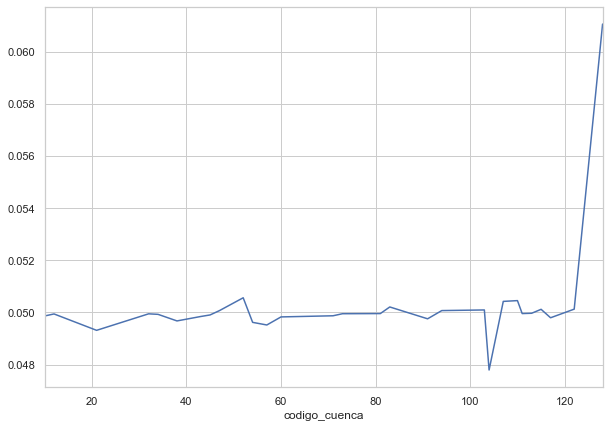

In [45]:
promedio_caudal_extremo_cuenca.plot()

A excepción de dos cuencas, el promedio de caudales extremos es muy similar entre todas las cuencas.

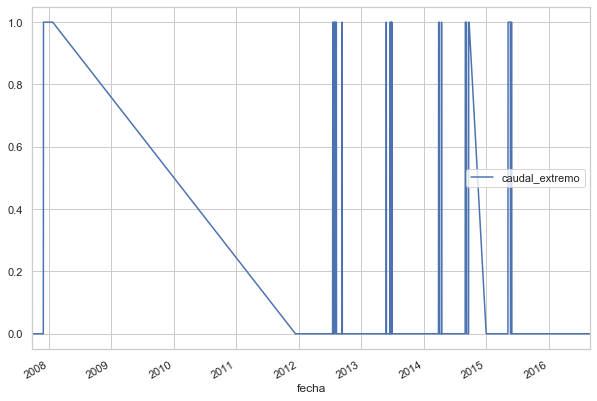

In [46]:
df[df['codigo_cuenca']==128].plot.line(x='fecha', y='caudal_extremo')

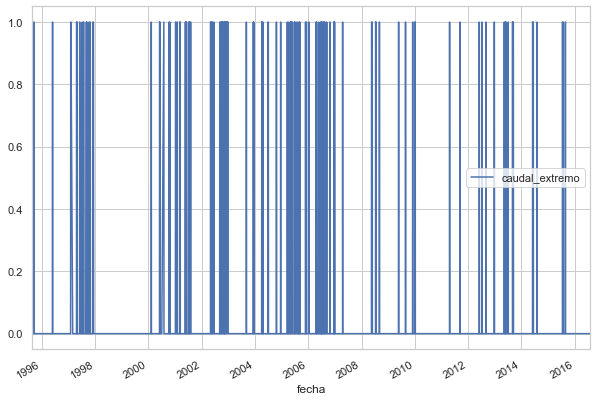

In [47]:
df[df['codigo_cuenca']==104].plot.line(x='fecha', y='caudal_extremo')

In [48]:
df['fecha'].describe()

count                 1256478
unique                  21172
top       2006-05-31 00:00:00
freq                      106
first     1960-01-11 00:00:00
last      2018-03-09 00:00:00
Name: fecha, dtype: object

Podemos pensar que la variación en los valores promedio de caudal extremo de las dos cuencas graficadas arriba se debe a que el rango de tiempo para el cual se ha recolectado mediciones es bastante limitado en ambos casos.

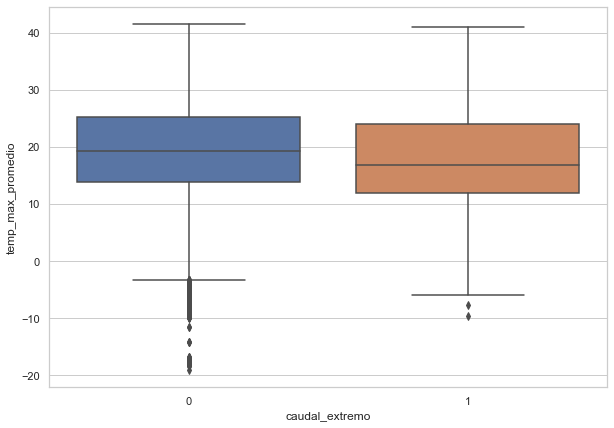

In [49]:
sb.boxplot(x='caudal_extremo' , y='temp_max_promedio', data=df)

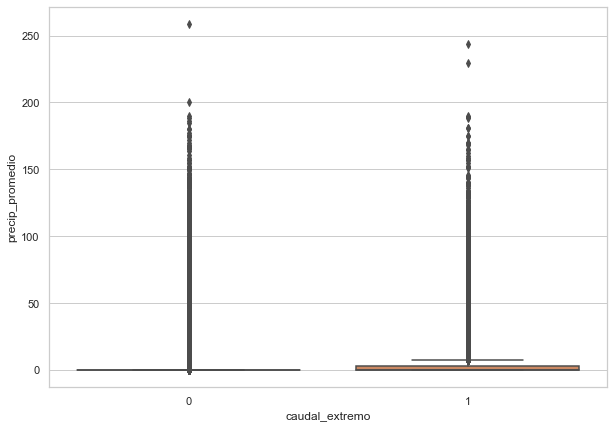

In [50]:
sb.boxplot(x='caudal_extremo' , y='precip_promedio', data=df)

En el par de boxplots graficados arriba tampoco se puede apreciar una clara correlación entre caudal extremo y las mediciones de precipitación y temperatura.

## 6. Hagan un plot del porcentaje de eventos extremos a través del tiempo (caudal_extremo, temp_extremo, precip_extremo). Se han vuelto más o menos comunes?

In [51]:
df['año'] = df['fecha'].dt.year
df['año'].head()

0    1965
1    1966
2    1966
3    1967
4    1968
Name: año, dtype: int64

In [52]:
pctaje_caudal_extremo = df.groupby(by=['codigo_estacion', 'año'])['caudal_extremo'].mean().rename('pctaje_caudal_extremo')
pctaje_caudal_extremo = pctaje_caudal_extremo.reset_index()
pctaje_caudal_extremo['pctaje_caudal_extremo'] = round((pctaje_caudal_extremo['pctaje_caudal_extremo']*100), 2)
pctaje_caudal_extremo.head()

codigo_estacion   año  pctaje_caudal_extremo
0          1020003  1985                   6.31
1          1020003  1986                   6.91
2          1020003  1987                   5.75
3          1020003  1988                   1.37
4          1020003  1989                   0.00

In [53]:
pctaje_temp_extremo = df.groupby(by=['codigo_estacion', 'año'])['temp_extremo'].mean().rename('pctaje_temp_extremo')
pctaje_temp_extremo = pctaje_temp_extremo.reset_index()
pctaje_temp_extremo['pctaje_temp_extremo'] = round((pctaje_temp_extremo['pctaje_temp_extremo']*100), 2)
pctaje_temp_extremo.head()

codigo_estacion   año  pctaje_temp_extremo
0          1020003  1985                 6.76
1          1020003  1986                 2.49
2          1020003  1987                15.62
3          1020003  1988                 9.29
4          1020003  1989                 5.47

In [54]:
pctaje_precip_extremo = df.groupby(by=['codigo_estacion', 'año'])['precip_extremo'].mean().rename('pctaje_precip_extremo')
pctaje_precip_extremo = pctaje_precip_extremo.reset_index()
pctaje_precip_extremo['pctaje_precip_extremo'] = round((pctaje_precip_extremo['pctaje_precip_extremo']*100), 2)
pctaje_precip_extremo.head()

codigo_estacion   año  pctaje_precip_extremo
0          1020003  1985                   7.21
1          1020003  1986                   6.63
2          1020003  1987                   6.58
3          1020003  1988                   3.01
4          1020003  1989                   1.82

In [55]:
df_pctaje_valores_extremos = pd.merge(pctaje_caudal_extremo, pctaje_temp_extremo, on=['codigo_estacion', 'año'])
df_pctaje_valores_extremos = pd.merge(df_pctaje_valores_extremos, pctaje_precip_extremo, on=['codigo_estacion', 'año'])
df_pctaje_valores_extremos.head()

codigo_estacion   año  pctaje_caudal_extremo  pctaje_temp_extremo  \
0          1020003  1985                   6.31                 6.76   
1          1020003  1986                   6.91                 2.49   
2          1020003  1987                   5.75                15.62   
3          1020003  1988                   1.37                 9.29   
4          1020003  1989                   0.00                 5.47   

   pctaje_precip_extremo  
0                   7.21  
1                   6.63  
2                   6.58  
3                   3.01  
4                   1.82

In [56]:
conteo = df.groupby(by=['codigo_estacion', 'año'])['caudal'].count().reset_index()
conteo = conteo.rename(columns={'caudal': 'observaciones_anuales'})
conteo.head()

codigo_estacion   año  observaciones_anuales
0          1020003  1985                    222
1          1020003  1986                    362
2          1020003  1987                    365
3          1020003  1988                    366
4          1020003  1989                    329

In [57]:
df_pctaje_valores_extremos = pd.merge(df_pctaje_valores_extremos, conteo, on=['codigo_estacion', 'año'])
df_pctaje_valores_extremos = df_pctaje_valores_extremos[df_pctaje_valores_extremos['observaciones_anuales'] > 300]
df_pctaje_valores_extremos.head()

codigo_estacion   año  pctaje_caudal_extremo  pctaje_temp_extremo  \
1          1020003  1986                   6.91                 2.49   
2          1020003  1987                   5.75                15.62   
3          1020003  1988                   1.37                 9.29   
4          1020003  1989                   0.00                 5.47   
5          1020003  1990                   0.00                11.45   

   pctaje_precip_extremo  observaciones_anuales  
1                   6.63                    362  
2                   6.58                    365  
3                   3.01                    366  
4                   1.82                    329  
5                   7.26                    358

In [58]:
def time_plot_pctaje_valores_extremos_estacion(codigo_estacion):
    data = df_pctaje_valores_extremos[df_pctaje_valores_extremos['codigo_estacion']==codigo_estacion]
    data = data.set_index('año')
    data = data[['pctaje_caudal_extremo', 'pctaje_temp_extremo', 'pctaje_precip_extremo']]
    data.plot.line()

In [59]:
codigos_aleatorios = df_pctaje_valores_extremos['codigo_estacion'].sample(13)
codigos_aleatorios

1341     4535002
3941    11542001
2707     7359001
3114     8313001
2860     8132001
797      3804002
3108     8313001
3789    11317001
1353     4537001
3590    10414001
3874    11337001
984      3825001
667      3434003
Name: codigo_estacion, dtype: int64

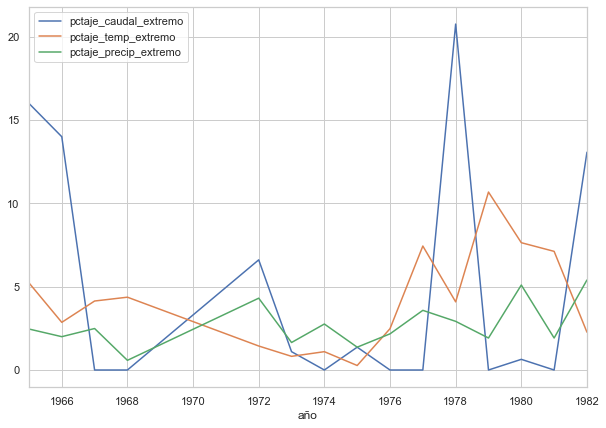

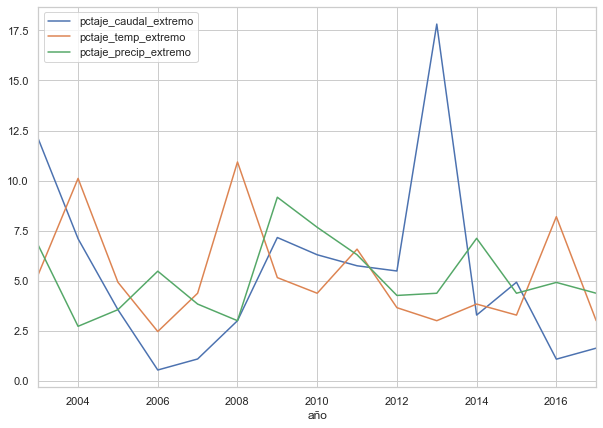

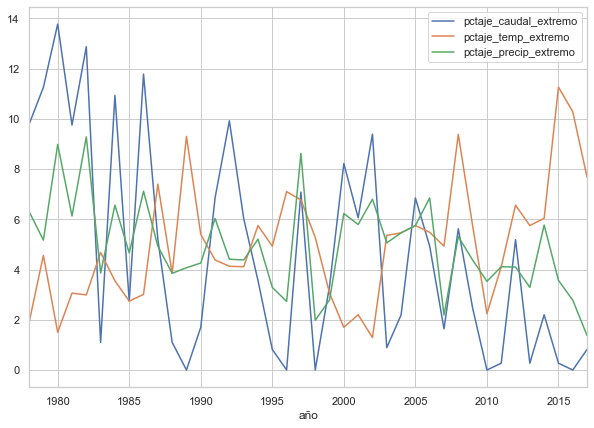

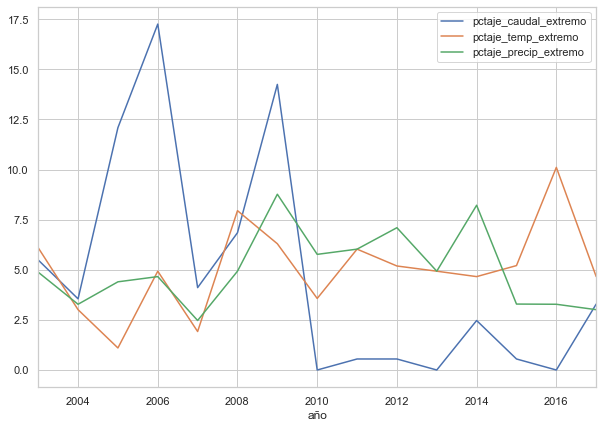

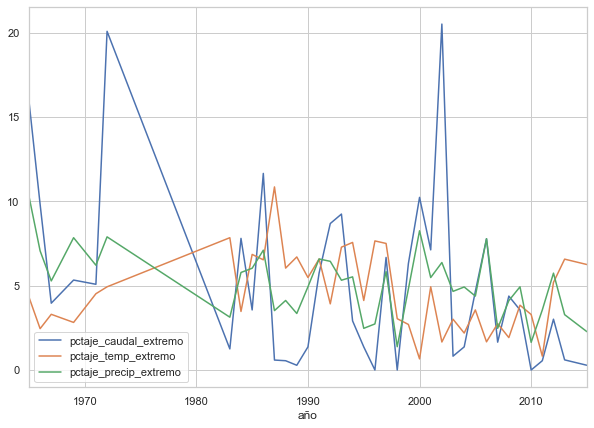

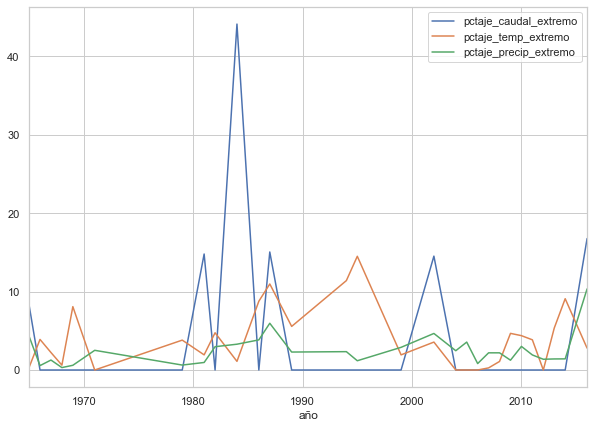

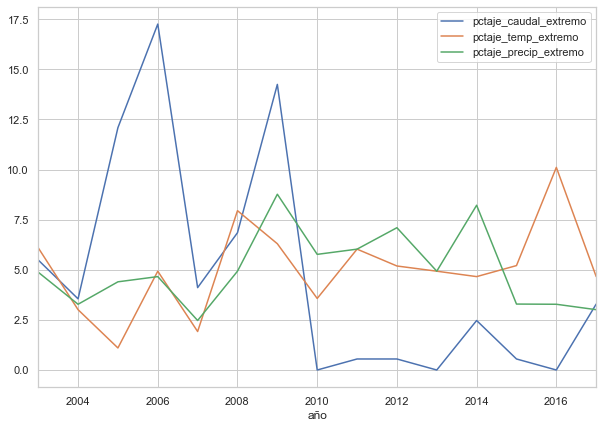

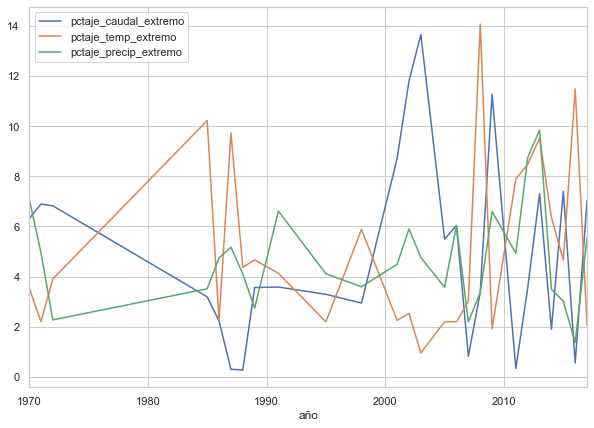

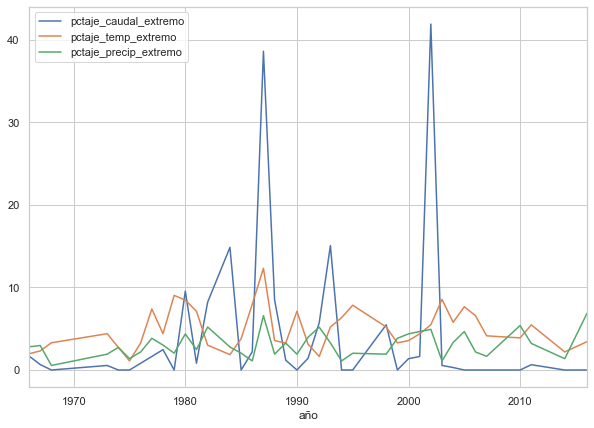

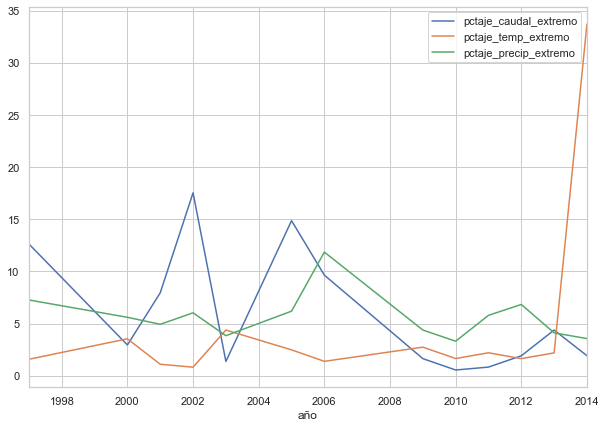

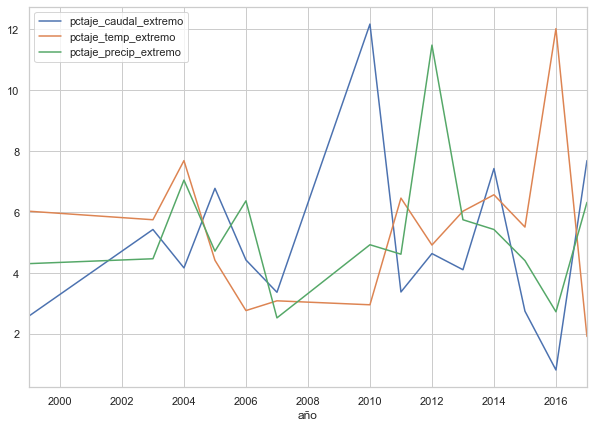

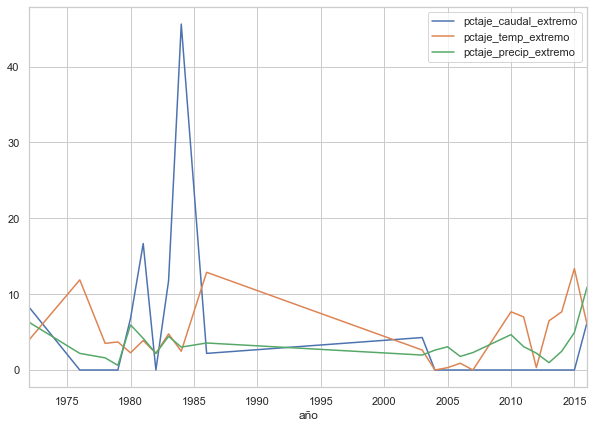

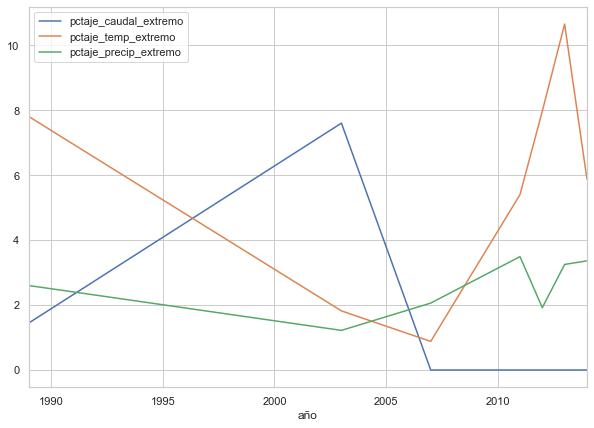

In [60]:
for codigo in codigos_aleatorios:
    time_plot_pctaje_valores_extremos_estacion(codigo)

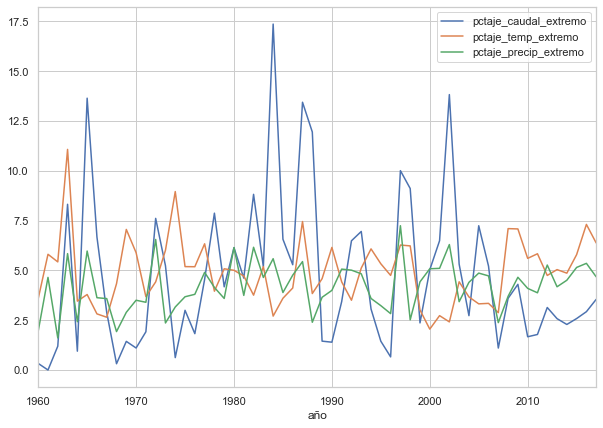

In [61]:
df_pctaje_valores_extremos.groupby(by='año')['pctaje_caudal_extremo'].mean().plot()
df_pctaje_valores_extremos.groupby(by='año')['pctaje_temp_extremo'].mean().plot()
df_pctaje_valores_extremos.groupby(by='año')['pctaje_precip_extremo'].mean().plot()
plt.legend()

En ningún de los gráficos mostrados en esta sección se puede apreciar una clara tendencia a que el porcentaje de eventos extremos haya aumentado en el tiempo.

## 7. Predicción de caudal extremo.

### ¿Qué datos podemos usar y cuáles no? Por supuesto, no podemos usar datos del futuro, pero ¿es lícito usar información del mismo día? ¿del día anterior? Todo depende de cómo propongas que el modelo se puede usar. Haz una propuesta de cómo usar tu modelo en la práctica (por ejemplo: una vez entrenado, voy a tomar los datos de XXX hasta el lunes y predecir para el día siguiente). Dada la propuesta, declara restricciones de información para caudal, temperatura y precipitación

Vamos a desarrollar un modelo predictivo que sirva para predecir con una día de antelación si el caudal será o no extremo, lo cual es válido y además tiene utilidad práctica, a diferencia de utilizar información del mismo día lo cual no parece tener mucho sentido, ya que la idea sería poder predecir con cierto tiempo de antelación este tipo de eventos para así tomar las medidas de prevención necesarias al respecto.

Debido a razones técnicas, vamos a preparar un set con datos de una sola estación de medición de caudal, para que así sea más fácil entrenar el modelo predictivo a desarrollar.

In [62]:
muestra_1 = df[df['codigo_estacion']==1020003][['caudal', 'precip_promedio', 'temp_max_promedio', 'fecha', 'caudal_extremo']]
muestra_1 = muestra_1.sort_values(by='fecha')
muestra_1 = muestra_1.set_index('fecha')
muestra_1 = muestra_1.dropna()
muestra_1.head(20)

caudal  precip_promedio  temp_max_promedio  caudal_extremo
fecha                                                                 
1985-01-01   0.041         5.066667               16.0               0
1985-01-02   0.052         8.455556               11.0               0
1985-01-03   0.099         8.433333               10.0               0
1985-01-04   0.078         7.966667               17.0               0
1985-01-05   0.080        10.400000                9.0               0
1985-01-07   0.127         1.188889               11.0               0
1985-01-08   0.138         3.133333               10.0               0
1985-01-09   0.119         2.711111               11.0               0
1985-01-10   0.086         1.144444               13.0               0
1985-01-11   0.073         0.000000               13.0               0
1985-01-12   0.076         0.000000               15.0               0
1985-01-14   0.052         0.000000               16.0               0
1985-01-15   0.036         1.311111               17.0               0
1985-01-16   0.043         4.377778               16.0               0
1985-01-17   0.047         1.877778               14.0               0
1985-01-18   0.043         0.000000               11.0               0
1985-01-19   0.055         0.000000               13.0               0
1985-01-21   0.075         0.000000               13.0               0
1985-01-22   0.043         0.444444               14.0               0
1985-01-23   0.061         0.222222               15.0               0

Para cada registro, se calculará el promedio de caudal, temp_max_promedio y precip_promedio de los últimos:

* 3 días.
* 7 días.
* 14 días.
* 30 días.

Luego, desplazamos los valores de caudal_extremo un día, de modo tal que los valores de caudal, temp_max_promedio y precip_promedio de un registro quedan alineados con el valor de caudal_extremo del día siguiente.

In [63]:
muestra_1['caudal_prom_3d'] = muestra_1['caudal'].rolling('3d').mean()
muestra_1['precip_prom_3d'] = muestra_1['precip_promedio'].rolling('3d').mean()
muestra_1['temp_prom_3d'] = muestra_1['temp_max_promedio'].rolling('3d').mean()

muestra_1['caudal_prom_7d'] = muestra_1['caudal'].rolling('7d').mean()
muestra_1['precip_prom_7d'] = muestra_1['precip_promedio'].rolling('7d').mean()
muestra_1['temp_prom_7d'] = muestra_1['temp_max_promedio'].rolling('7d').mean()

muestra_1['caudal_prom_14d'] = muestra_1['caudal'].rolling('14d').mean()
muestra_1['precip_prom_14d'] = muestra_1['precip_promedio'].rolling('14d').mean()
muestra_1['temp_prom_14d'] = muestra_1['temp_max_promedio'].rolling('14d').mean()

muestra_1['caudal_prom_30d'] = muestra_1['caudal'].rolling('30d').mean()
muestra_1['precip_prom_30d'] = muestra_1['precip_promedio'].rolling('30d').mean()
muestra_1['temp_prom_30d'] = muestra_1['temp_max_promedio'].rolling('30d').mean()

muestra_1['caudal_extremo'] = muestra_1['caudal_extremo'].shift(periods=-1)
muestra_1 = muestra_1.dropna()

muestra_1.head(20)

caudal  precip_promedio  temp_max_promedio  caudal_extremo  \
fecha                                                                    
1985-01-01   0.041         5.066667               16.0             0.0   
1985-01-02   0.052         8.455556               11.0             0.0   
1985-01-03   0.099         8.433333               10.0             0.0   
1985-01-04   0.078         7.966667               17.0             0.0   
1985-01-05   0.080        10.400000                9.0             0.0   
1985-01-07   0.127         1.188889               11.0             0.0   
1985-01-08   0.138         3.133333               10.0             0.0   
1985-01-09   0.119         2.711111               11.0             0.0   
1985-01-10   0.086         1.144444               13.0             0.0   
1985-01-11   0.073         0.000000               13.0             0.0   
1985-01-12   0.076         0.000000               15.0             0.0   
1985-01-14   0.052         0.000000               16.0             0.0   
1985-01-15   0.036         1.311111               17.0             0.0   
1985-01-16   0.043         4.377778               16.0             0.0   
1985-01-17   0.047         1.877778               14.0             0.0   
1985-01-18   0.043         0.000000               11.0             0.0   
1985-01-19   0.055         0.000000               13.0             0.0   
1985-01-21   0.075         0.000000               13.0             0.0   
1985-01-22   0.043         0.444444               14.0             0.0   
1985-01-23   0.061         0.222222               15.0             0.0   

            caudal_prom_3d  precip_prom_3d  temp_prom_3d  caudal_prom_7d  \
fecha                                                                      
1985-01-01        0.041000    5.066667e+00     16.000000        0.041000   
1985-01-02        0.046500    6.761111e+00     13.500000        0.046500   
1985-01-03        0.064000    7.318519e+00     12.333333        0.064000   
1985-01-04        0.076333    8.285185e+00     12.666667        0.067500   
1985-01-05        0.085667    8.933333e+00     12.000000        0.070000   
1985-01-07        0.103500    5.794444e+00     10.000000        0.079500   
1985-01-08        0.132500    2.161111e+00     10.500000        0.095667   
1985-01-09        0.128000    2.344444e+00     10.666667        0.106833   
1985-01-10        0.114333    2.329630e+00     11.333333        0.104667   
1985-01-11        0.092667    1.285185e+00     12.333333        0.103833   
1985-01-12        0.078333    3.814815e-01     13.666667        0.103167   
1985-01-14        0.064000    7.771561e-16     15.500000        0.090667   
1985-01-15        0.044000    6.555555e-01     16.500000        0.073667   
1985-01-16        0.043667    1.896296e+00     16.333333        0.061000   
1985-01-17        0.042000    2.522222e+00     15.666667        0.054500   
1985-01-18        0.044333    2.085185e+00     13.666667        0.049500   
1985-01-19        0.048333    6.259259e-01     12.666667        0.046000   
1985-01-21        0.065000    9.992007e-16     13.000000        0.049833   
1985-01-22        0.059000    2.222222e-01     13.500000        0.051000   
1985-01-23        0.059667    2.222222e-01     14.000000        0.054000   

            precip_prom_7d  temp_prom_7d  caudal_prom_14d  precip_prom_14d  \
fecha                                                                        
1985-01-01        5.066667     16.000000         0.041000         5.066667   
1985-01-02        6.761111     13.500000         0.046500         6.761111   
1985-01-03        7.318519     12.333333         0.064000         7.318519   
1985-01-04        7.480556     13.500000         0.067500         7.480556   
1985-01-05        8.064444     12.600000         0.070000         8.064444   
1985-01-07        6.918519     12.333333         0.079500         6.918519   
1985-01-08        6.596296     11.333333         0.087857         6.377778   
1985-01-

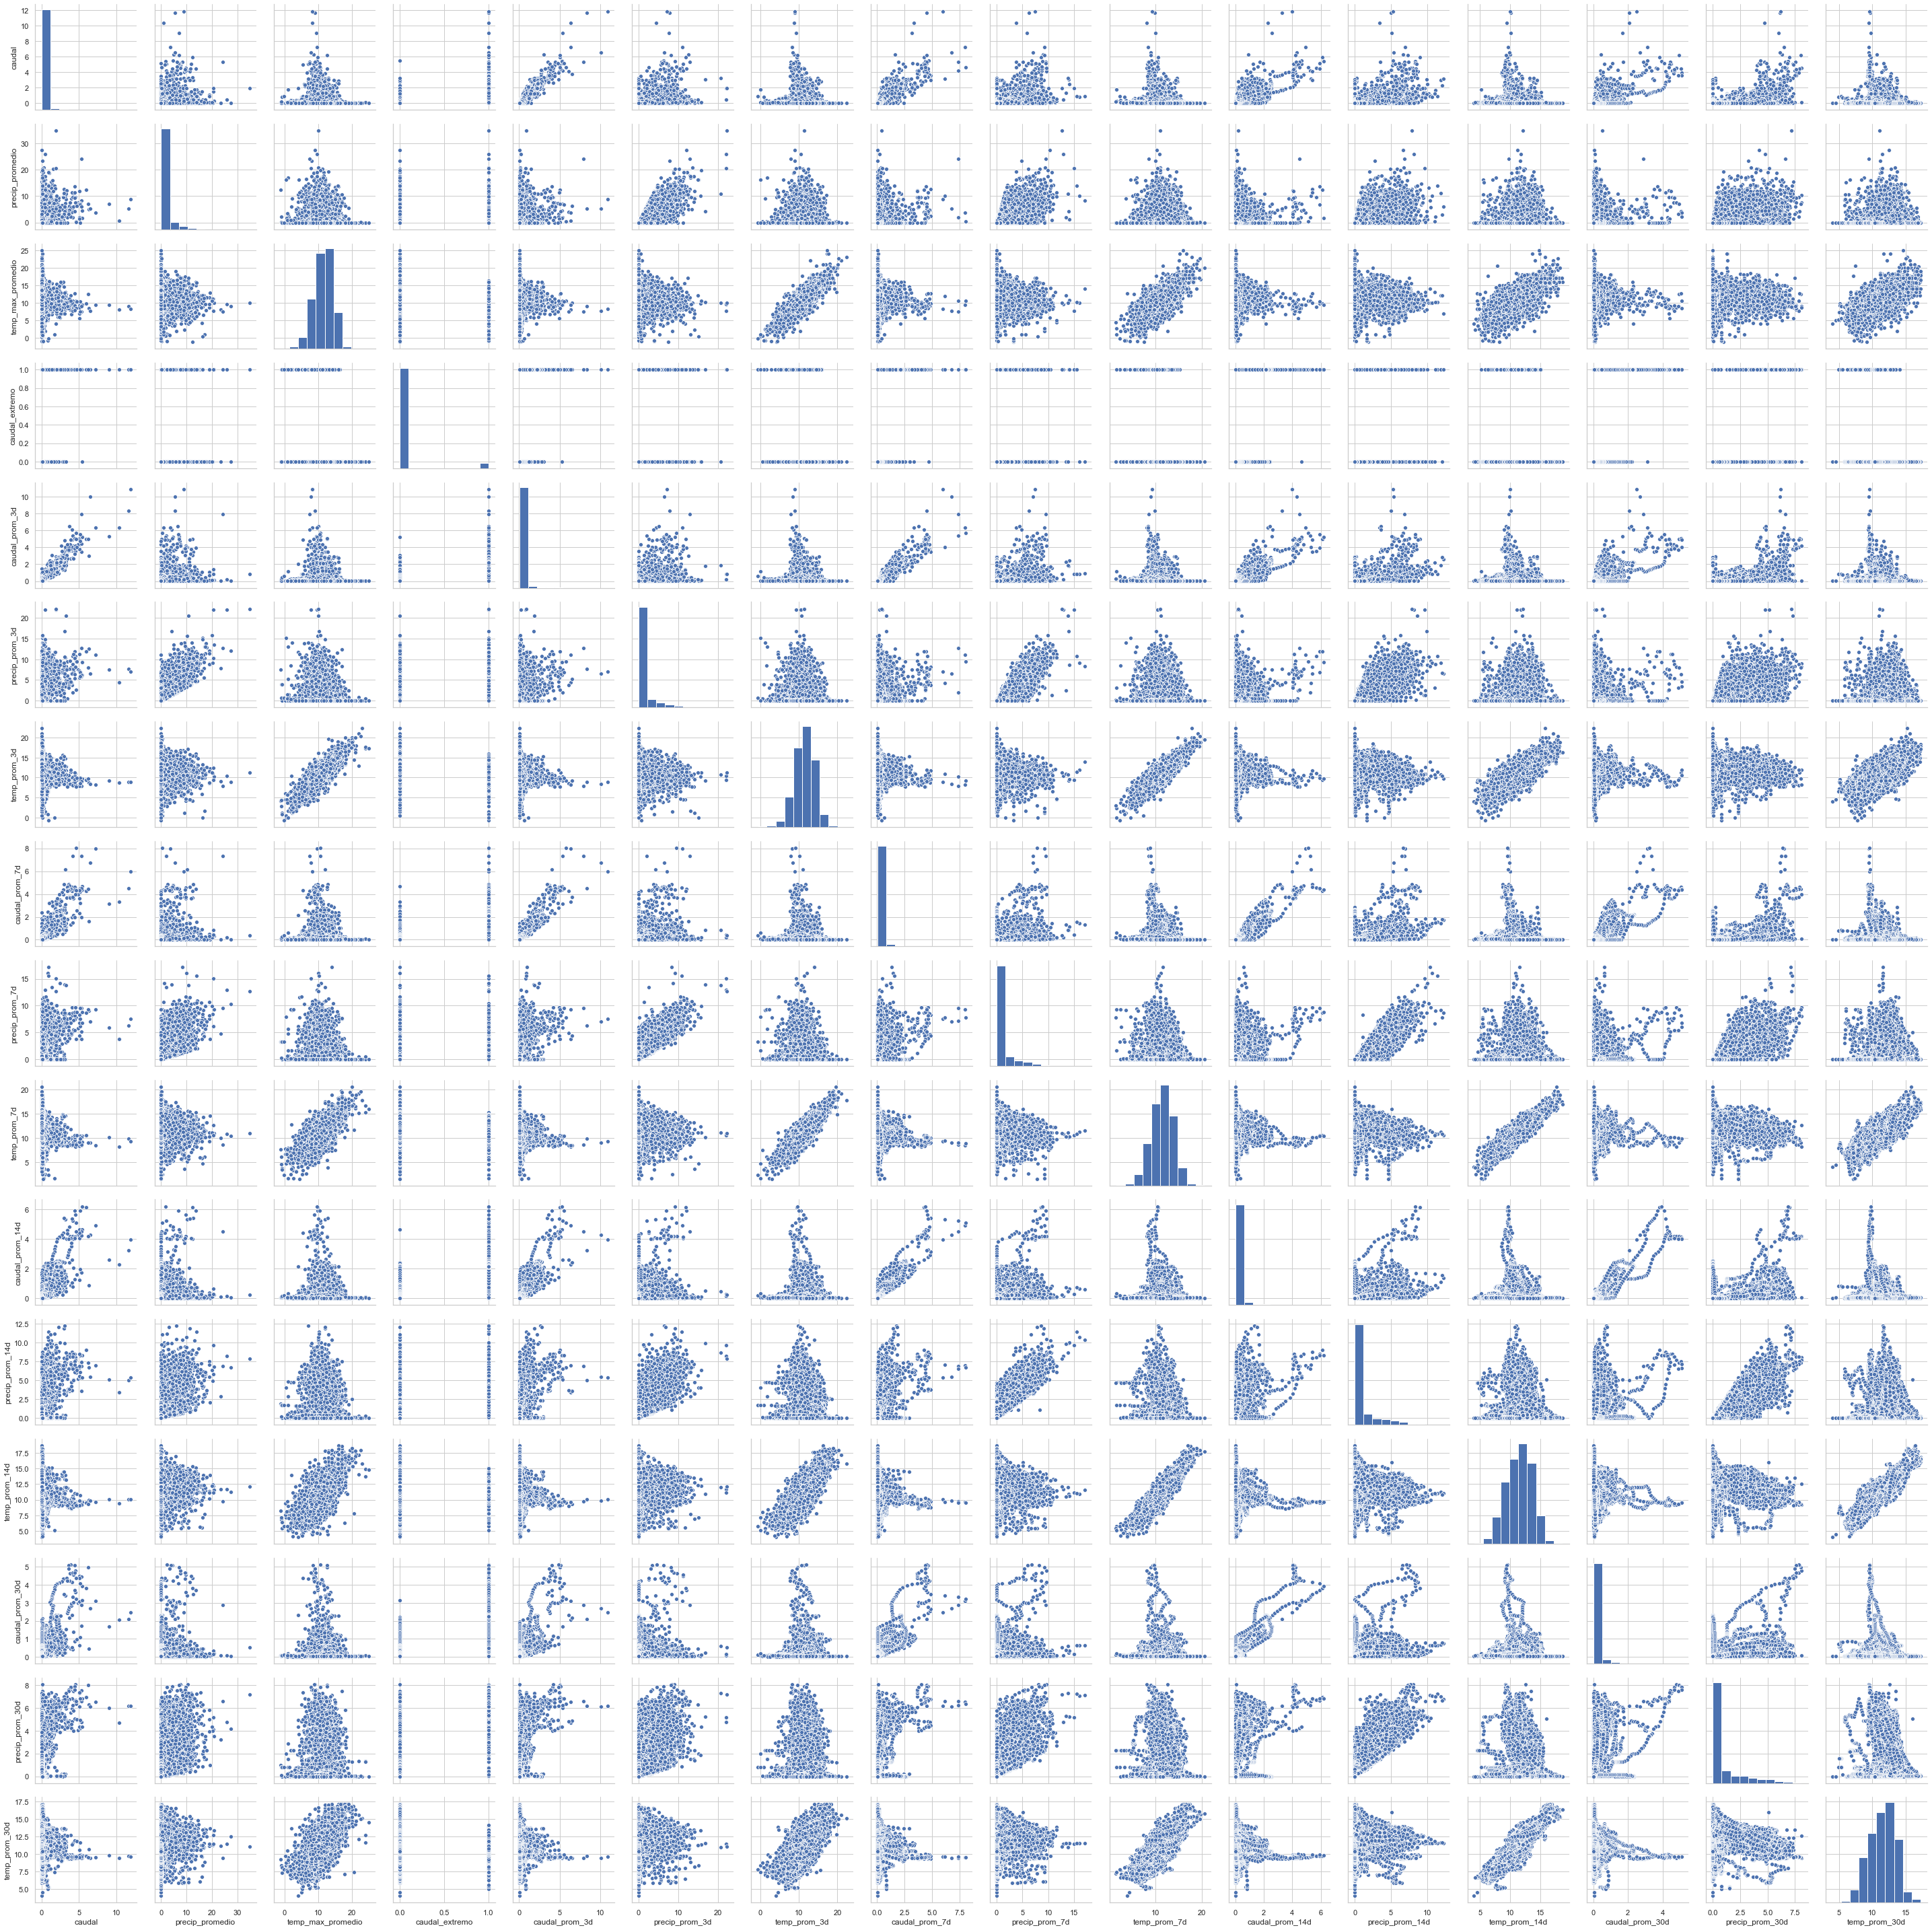

In [64]:
sb.pairplot(muestra_1)

En los histogramas graficados arriba podemos apreciar una vez más que sólo los variables correspondientes a medición de temperatura presentan una distribución cercana a normal, mientras que en el caso de las variables de medición de caudal y precipitación se mantiene la distribución asimétrica positiva. Ahora, vamos a calcular las correlaciones tanto de Pearson como de Spearman para cada una de las variables creadas vs. la variable dependiente caudal_extremo.

In [65]:
muestra_1.corr()['caudal_extremo'].sort_values(ascending=False)

caudal_extremo       1.000000
caudal               0.598690
caudal_prom_3d       0.573276
caudal_prom_7d       0.551318
caudal_prom_14d      0.528500
caudal_prom_30d      0.496223
precip_prom_30d      0.230701
precip_prom_3d       0.227176
precip_prom_7d       0.224214
precip_prom_14d      0.221075
precip_promedio      0.191829
temp_max_promedio   -0.115194
temp_prom_3d        -0.121756
temp_prom_7d        -0.131050
temp_prom_14d       -0.131667
temp_prom_30d       -0.144981
Name: caudal_extremo, dtype: float64

In [66]:
muestra_1.corr(method='spearman')['caudal_extremo'].sort_values(ascending=False)

caudal_extremo       1.000000
caudal               0.347494
caudal_prom_3d       0.339714
caudal_prom_7d       0.329647
caudal_prom_14d      0.319964
caudal_prom_30d      0.306706
precip_promedio      0.145748
precip_prom_3d       0.137798
precip_prom_30d      0.116425
precip_prom_14d      0.110456
precip_prom_7d       0.098540
temp_max_promedio   -0.116884
temp_prom_3d        -0.123453
temp_prom_7d        -0.134510
temp_prom_14d       -0.139715
temp_prom_30d       -0.142480
Name: caudal_extremo, dtype: float64

Finalmente preparamos el dataset con el cual entrenaremos y evaluaremos nuestro modelo predictivo con las variables de caudal, temperatura y precipitación que más correlación tengan con la variable caudal_extremo, que en este caso son:

* Caudal del día actual (recordemos que es para predecir si el caudal del siguiente será extremo o no).
* Promedio de precipitaciones de los últimos 3 días.
* Promedio de temperaturas de los últimos 30 días.

In [67]:
ml_data = muestra_1[['caudal', 'precip_prom_3d', 'temp_prom_30d', 'caudal_extremo']]
ml_data.head(20)

caudal  precip_prom_3d  temp_prom_30d  caudal_extremo
fecha                                                            
1985-01-01   0.041    5.066667e+00      16.000000             0.0
1985-01-02   0.052    6.761111e+00      13.500000             0.0
1985-01-03   0.099    7.318519e+00      12.333333             0.0
1985-01-04   0.078    8.285185e+00      13.500000             0.0
1985-01-05   0.080    8.933333e+00      12.600000             0.0
1985-01-07   0.127    5.794444e+00      12.333333             0.0
1985-01-08   0.138    2.161111e+00      12.000000             0.0
1985-01-09   0.119    2.344444e+00      11.875000             0.0
1985-01-10   0.086    2.329630e+00      12.000000             0.0
1985-01-11   0.073    1.285185e+00      12.100000             0.0
1985-01-12   0.076    3.814815e-01      12.363636             0.0
1985-01-14   0.052    7.771561e-16      12.666667             0.0
1985-01-15   0.036    6.555555e-01      13.000000             0.0
1985-01-16   0.043    1.896296e+00      13.214286             0.0
1985-01-17   0.047    2.522222e+00      13.266667             0.0
1985-01-18   0.043    2.085185e+00      13.125000             0.0
1985-01-19   0.055    6.259259e-01      13.117647             0.0
1985-01-21   0.075    9.992007e-16      13.111111             0.0
1985-01-22   0.043    2.222222e-01      13.157895             0.0
1985-01-23   0.061    2.222222e-01      13.250000             0.0

In [68]:
features = ml_data.drop('caudal_extremo', axis=1)
labels = ml_data['caudal_extremo']

labels.value_counts()

0.0    10582
1.0      558
Name: caudal_extremo, dtype: int64

Aplicamos una técnica de undersampling para reducir en la medida de lo posible el desbalance entre las dos categorías de la variable a predecir.

In [69]:
tomek = TomekLinks()
X_res, y_res = tomek.fit_resample(features, labels)

ceros = [x for x in y_res if x==0]
unos = [x for x in y_res if x==1]

print(len(ceros))
print(len(unos))

10476
558


Partición del set de datos en set de entrenamiento y set de prueba.

In [70]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=0)

for dataset in [y_train, y_test]:
    print(round(len(dataset) / len(labels), 2))

0.7
0.3


In [71]:
def print_best_score(hp_optimizer):
    print('BEST SCORE: {} - PARAMS: {}\n'.format(round(hp_optimizer.best_score_, 3), hp_optimizer.best_params_))
    means = hp_optimizer.cv_results_['mean_test_score']
    stds = hp_optimizer.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, hp_optimizer.cv_results_['params']):
        print('Score: {} (+/-{}) for Params: {}'.format(round(mean, 3), round(std * 2, 3), params))

In [72]:
def evaluate_model(name, model, features, labels):
    start = time()
    pred = model.predict(features)
    end = time()
    accuracy = round(accuracy_score(labels, pred), 3)
    precision = round(precision_score(labels, pred), 3)
    recall = round(recall_score(labels, pred), 3)
    print('{} -- Accuracy: {} / Precision: {} / Recall: {} / Latency: {}ms'.format(name,
                                                                                   accuracy,
                                                                                   precision,
                                                                                   recall,
                                                                                   round((end - start)*1000, 1)))

### Modelo 1: Logistic Regression

In [73]:
lr = LogisticRegression()
parameters = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

CV_1 = GridSearchCV(lr, parameters, cv=5, iid=False, scoring='recall')
CV_1.fit(X_train, y_train.values.ravel())

print_best_score(CV_1)

BEST SCORE: 0.466 - PARAMS: {'solver': 'newton-cg'}

Score: 0.466 (+/-0.095) for Params: {'solver': 'newton-cg'}
Score: 0.466 (+/-0.095) for Params: {'solver': 'lbfgs'}
Score: 0.466 (+/-0.095) for Params: {'solver': 'liblinear'}
Score: 0.466 (+/-0.095) for Params: {'solver': 'sag'}
Score: 0.466 (+/-0.095) for Params: {'solver': 'saga'}


In [74]:
LR = CV_1.best_estimator_

lr_y_pred = LR.predict(X_test)
confusion_matrix(y_test, lr_y_pred)

array([[3136,   28],
       [  90,   88]], dtype=int64)

In [75]:
evaluate_model('LR', LR, X_test, y_test)

LR -- Accuracy: 0.965 / Precision: 0.759 / Recall: 0.494 / Latency: 0.0ms


### Modelo 2: Random Forest

In [76]:
rf = RandomForestClassifier()
parameters = {
    'n_estimators': [10, 50, 70, 80, 90, 100, 110, 120, 150, 200, 300, 400, 500, 600, 700]
}

CV_2 = GridSearchCV(rf, parameters, cv=5, iid=False, scoring='recall')
CV_2.fit(X_train.values, y_train.values.ravel())

print_best_score(CV_2)

BEST SCORE: 0.618 - PARAMS: {'n_estimators': 120}

Score: 0.576 (+/-0.11) for Params: {'n_estimators': 10}
Score: 0.613 (+/-0.116) for Params: {'n_estimators': 50}
Score: 0.616 (+/-0.1) for Params: {'n_estimators': 70}
Score: 0.605 (+/-0.12) for Params: {'n_estimators': 80}
Score: 0.603 (+/-0.1) for Params: {'n_estimators': 90}
Score: 0.611 (+/-0.121) for Params: {'n_estimators': 100}
Score: 0.616 (+/-0.093) for Params: {'n_estimators': 110}
Score: 0.618 (+/-0.094) for Params: {'n_estimators': 120}
Score: 0.611 (+/-0.098) for Params: {'n_estimators': 150}
Score: 0.6 (+/-0.109) for Params: {'n_estimators': 200}
Score: 0.618 (+/-0.109) for Params: {'n_estimators': 300}
Score: 0.611 (+/-0.103) for Params: {'n_estimators': 400}
Score: 0.608 (+/-0.117) for Params: {'n_estimators': 500}
Score: 0.611 (+/-0.116) for Params: {'n_estimators': 600}
Score: 0.608 (+/-0.099) for Params: {'n_estimators': 700}


In [77]:
RF = CV_2.best_estimator_

rf_y_pred = RF.predict(X_test)
confusion_matrix(y_test, rf_y_pred)

array([[3131,   33],
       [  57,  121]], dtype=int64)

In [78]:
evaluate_model('RF', RF, X_test, y_test)

RF -- Accuracy: 0.973 / Precision: 0.786 / Recall: 0.68 / Latency: 187.5ms


### Modelo 3: Gradient Boosting

In [79]:
gb = GradientBoostingClassifier()
parameters = {
    'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
}

CV_3 = GridSearchCV(gb, parameters, cv=5, iid=False, scoring='recall')
CV_3.fit(X_train, y_train.values.ravel())

print_best_score(CV_3)

BEST SCORE: 0.642 - PARAMS: {'n_estimators': 30}

Score: 0.558 (+/-0.092) for Params: {'n_estimators': 10}
Score: 0.632 (+/-0.097) for Params: {'n_estimators': 20}
Score: 0.642 (+/-0.095) for Params: {'n_estimators': 30}
Score: 0.642 (+/-0.095) for Params: {'n_estimators': 40}
Score: 0.642 (+/-0.095) for Params: {'n_estimators': 50}
Score: 0.637 (+/-0.091) for Params: {'n_estimators': 60}
Score: 0.637 (+/-0.081) for Params: {'n_estimators': 70}
Score: 0.637 (+/-0.081) for Params: {'n_estimators': 80}
Score: 0.632 (+/-0.08) for Params: {'n_estimators': 90}
Score: 0.632 (+/-0.08) for Params: {'n_estimators': 100}


In [80]:
GB = CV_3.best_estimator_

gb_y_pred = GB.predict(X_test)
confusion_matrix(y_test, gb_y_pred)

array([[3126,   38],
       [  55,  123]], dtype=int64)

In [81]:
evaluate_model('GB', GB, X_test, y_test)

GB -- Accuracy: 0.972 / Precision: 0.764 / Recall: 0.691 / Latency: 31.3ms


## 8. Análisis de resultado del modelo

### a. Qué performance tiene el modelo? Qué métricas usaste para medir esa performance? Cuáles son las variables más importantes? Qué opinión te merecen los resultados?

La métrica utilizada para la evaluación de los modelos entrenados es la sensibilidad o "recall", la cual en este caso nos muestra la proporción de caudales extremos positivos correctamente predecidos con respecto al total de caudales extremos positivos registrados en el set de datos. De los tres modelos evaluados, el que tuvo mejor desempeño fue el de Gradient Boosting, el cual obtuvo un 69% en la métrica de sensibilidad al ser evaluado con el set de datos de prueba.

### b. Si quisiéramos capturar alrededor de un 70% de los eventos de caudales extremos. Cuál es la precisión de tu modelo con ese porcentaje de captura? Cuéntanos si te parece útil.

La precisión del mejor modelo evaluado (Gradient Boosting) es del 76.4% con la sensibilidad ya mencionada del 69%. La medida de precisión en este caso también es útil ya que mientras menos eventos no extremos sean predecidos como extremos pues es mejor, aunque no tiene el mismo nivel de criticidad que la sensibilidad del modelo.